<a id='1'></a>
# 数据探索

In [16]:
#encoding: utf-8

import pandas as pd
data = pd.read_csv('data/data.csv', encoding='GB18030')
print(data.shape)

(4754, 90)


## 去重

去掉重复数据，即那些属性都一样的数据。

In [17]:
data.drop_duplicates(inplace=True)
print(data.shape)

(4754, 90)


<a id='1.1'></a>
## 删除和预测无关的数据

**删除原则**

* 特征只有单一的值，即该特征所有样本值都一样
* 特征属性值个数和行数相同
* 特征和预测无关

(4754, 0)
(4754, 83)
(4754, 7)
(4754, 0)
(4754, 0)
(4754, 0)
<class 'pandas.core.series.Series'>
student_feature                     0.630627
cross_consume_count_last_1_month    0.089609
query_org_count                     0.063946
query_cash_count                    0.063946
latest_six_month_apply              0.063946
latest_three_month_apply            0.063946
query_sum_count                     0.063946
latest_one_month_apply              0.063946
query_finance_count                 0.063946
apply_credibility                   0.063946
dtype: float64
0       1
1       0
2       1
3       0
4       1
5       0
6       0
7       0
8       0
9       1
10      1
11      0
12      0
13      0
14      1
15      1
16      1
17      0
18      0
19      1
20      1
21      0
22      0
23      0
24      0
25      1
26      0
27      0
28      0
29      0
       ..
4724    1
4725    0
4726    0
4727    0
4728    0
4729    0
4730    1
4731    0
4732    0
4733    1
4734    1
4735    1
4736    

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

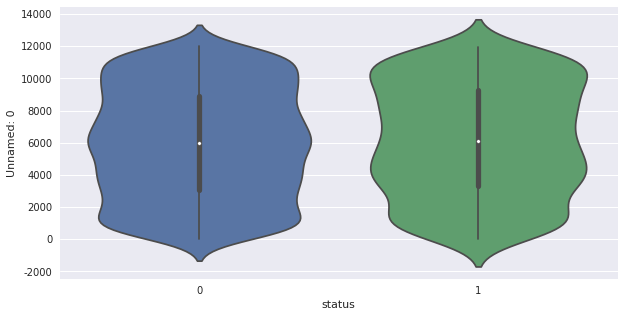

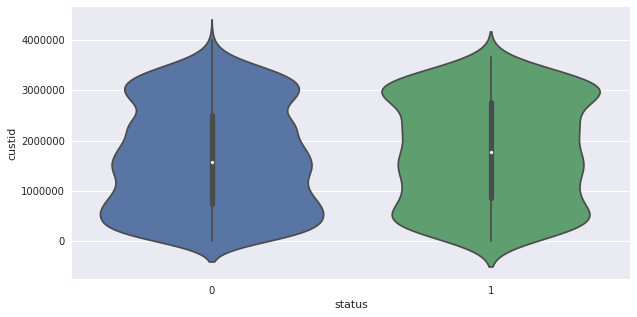

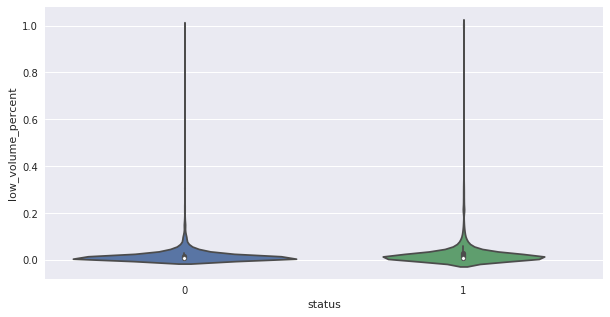

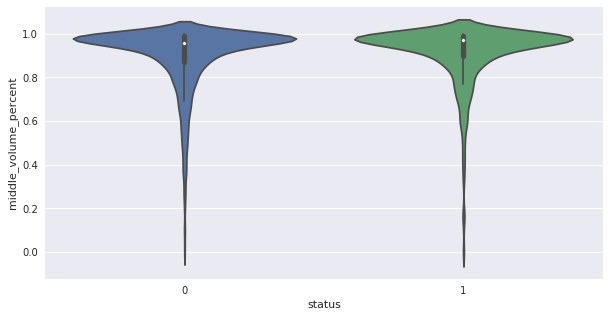

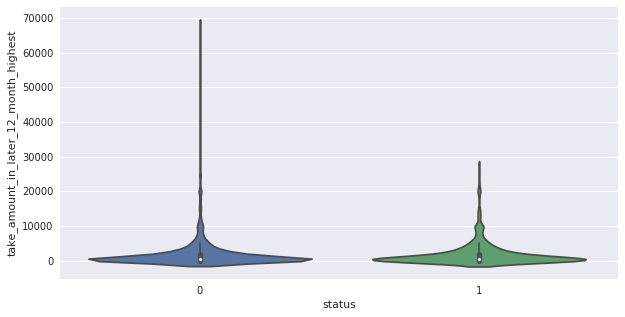

In [240]:
# 查看每列的类型
types = data.dtypes
# print(len(types))
# print types[0:45]
# print('-----------------------------------------------------------')
# print types[45:]

print data.select_dtypes(include=['bool']).shape
print data.select_dtypes(include=['number']).shape
print data.select_dtypes(include=['object']).shape
print data.select_dtypes(include=['datetime']).shape
print data.select_dtypes(include=['timedelta']).shape
print data.select_dtypes(include=['category']).shape

# 特征类型划分：数字型特征、字符型特征、日期特征
# fancyimpute是python的第三方工具包，主要提供了各种矩阵计算、填充算法的实现。
# https://blog.csdn.net/jingyi130705008/article/details/82796283

# 数据可视化：https://www.cnblogs.com/jin-liang/p/9011771.html

# 取出数值型特征，观察缺失及分布情况
# 取出数值型变量
X_num = data.select_dtypes(['number']).copy()
# 查看缺失情况
num_miss_rate = 1 - X_num.count() / len(X_num)
print type(num_miss_rate)
num_miss_rate.sort_values(ascending=False, inplace=True)
print(num_miss_rate[:10])
num_miss_rate.plot()

X_num = data.select_dtypes(['number']).copy()
# 观察数据分布
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
 
print y

for i, col in enumerate(X_num.columns[:5]):
    plt.figure(i + 1, figsize=(10, 5))
    # # 密度分布图
    # sns.distplot(X_num[col][y==1].dropna(), hist=True, kde=True)
    # sns.distplot(X_num[col][y==0].dropna(), hist=True, kde=True)
    # 分箱图
    # sns.boxplot(y=X_num[col], x=y)
    # 小提琴图
    # sns.violinplot(y=X_num[col])
    sns.violinplot(x=y, y=X_num[col])

# 从图像可以看出，数据中含有极端值的比较多，可使用 IQR 方法对极端值进行处理。
# 也就是说，分别使用 Q3 + 1.5IQR和 Q1 - 1.5IQR 对上下极端值进行修正。
# 极端值处理函数
def iqr_outlier(x, thre=1.5):
    x_cl = x.copy()
    q25, q75 = x.quantile(q=[0.25, 0.75])
    iqr = q75 - q25
    top = q75 + thre * iqr
    bottom = q25 - thre * iqr
 
    x_cl[x_cl > top] = top
    x_cl[x_cl < bottom] = bottom
 
    return x_cl
 
# 对进行缺失值填充后的数据集进行极端值修正
X_num_cl = pd.DataFrame()
for col in X_num.columns:
    X_num_cl[col] = iqr_outlier(X_num[col])

X_num = X_num_cl

# 字符型变量，观察缺失值以及分布
X_str = X.select_dtypes(exclude='number').copy()
X_str.describe()
# 众数填充
X_str['reg_preference_for_trad'] = X_str['reg_preference_for_trad'].fillna(X_str['reg_preference_for_trad'].mode()[0])
# 哑变量
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])
# 数字编码
X_str_map = X_str['reg_preference_for_trad'].map({'一线城市': 0, '二线城市': 1,'三线城市': 2,  '其他城市': 3, '境外': 4})

In [18]:
# 1表示某列无缺失值情况下，所有值都一样；
# 2表示有缺失值情况下，所有值都一样
# count表示无缺失值情况下，所有值都不一样
# 表示有缺失值情况下，所有值都不一样
# 但对于离散值，其实所有值都一样也没关系
for i in data.columns:
    count = data[i].count()
    if len(list(data[i].unique())) in [1, count, count - 1]:
        print(i)

Unnamed: 0
custid
trade_no
bank_card_no
source


In [19]:
# 'source'和'bank_card_no'值无区分度
# ‘custid’、‘trade_no’、‘id_name’和预测无关
data.drop(['custid', 'trade_no', 'bank_card_no', 'id_name', 'source'], axis = 1, inplace=True)

In [20]:
# 'Unnamed: 0'和预测无关
data.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [21]:
first_transaction_time = data['first_transaction_time']
latest_query_time = data['latest_query_time']
loans_latest_time = data['loans_latest_time']
# 先删除data
data.drop(['first_transaction_time', 'latest_query_time', 'loans_latest_time'], axis = 1, inplace=True)

In [22]:
# 探索处理日期类型的方法
print len(first_transaction_time.unique())
print len(latest_query_time.unique())
print len(loans_latest_time.unique())

# print first_transaction_time[1]

latest_query_time_month = pd.to_datetime(latest_query_time).dt.month # 月
latest_query_time_weekday = pd.to_datetime(latest_query_time).dt.weekday # 星期
latest_query_time_day = pd.to_datetime(latest_query_time).dt.day # 天
 
loans_latest_time_month = pd.to_datetime(loans_latest_time).dt.month # 月
loans_latest_time_weekday = pd.to_datetime(loans_latest_time).dt.weekday # 星期
loans_latest_time_day = pd.to_datetime(loans_latest_time).dt.day # 天

data['latest_query_time_month'] = latest_query_time_month
data['latest_query_time_weekday'] = latest_query_time_weekday
data['latest_query_time_day'] = latest_query_time_day
data['loans_latest_time_month'] = loans_latest_time_month
data['loans_latest_time_weekday'] = loans_latest_time_weekday
data['loans_latest_time_day'] = loans_latest_time_day

latest_query_time_month = latest_query_time_month.as_matrix()
latest_query_time_month = latest_query_time_month.reshape(len(latest_query_time_month), 1)

latest_query_time_weekday = latest_query_time_weekday.as_matrix()
latest_query_time_weekday = latest_query_time_weekday.reshape(len(latest_query_time_weekday), 1)

latest_query_time_day = latest_query_time_day.as_matrix()
latest_query_time_day = latest_query_time_day.reshape(len(latest_query_time_day), 1)

loans_latest_time_month = loans_latest_time_month.as_matrix()
loans_latest_time_month = loans_latest_time_month.reshape(len(loans_latest_time_month), 1)

loans_latest_time_weekday = loans_latest_time_weekday.as_matrix()
loans_latest_time_weekday = loans_latest_time_weekday.reshape(len(loans_latest_time_weekday), 1)

loans_latest_time_day = loans_latest_time_day.as_matrix()
loans_latest_time_day = loans_latest_time_day.reshape(len(loans_latest_time_day), 1)

1694
208
233


<a id='1.2'></a>
## 查看行列缺失比例

In [23]:
# 统计各个列缺失值所占比例
for i in data.columns:
    d = len(data) - data[i].count()
    r = (float(d) / len(data)) * 100
    # rate = '%.2f%%' % r
    # print 'name: ', str(i).ljust(10),'d: ', str(d).ljust(4), 'rate: ', rate
    print '%.2f%%' % r, i

# 由下图统计可以看出，‘student_feature’列缺失一半以上，且本列为类别类型，可以将缺失值用-1填充，相当于“是否缺失”当成另一种类别。
# 其他列缺失概率比较小，可以用中值填充。

0.04% low_volume_percent
0.04% middle_volume_percent
0.00% take_amount_in_later_12_month_highest
0.06% trans_amount_increase_rate_lately
0.04% trans_activity_month
0.04% trans_activity_day
0.04% transd_mcc
0.17% trans_days_interval_filter
0.04% trans_days_interval
0.04% regional_mobility
63.06% student_feature
0.00% repayment_capability
0.00% is_high_user
0.04% number_of_trans_from_2011
0.00% historical_trans_amount
0.04% historical_trans_day
0.04% rank_trad_1_month
0.00% trans_amount_3_month
0.04% avg_consume_less_12_valid_month
0.00% abs
0.04% top_trans_count_last_1_month
0.00% avg_price_last_12_month
2.19% avg_price_top_last_12_valid_month
0.04% reg_preference_for_trad
0.17% trans_top_time_last_1_month
0.17% trans_top_time_last_6_month
0.17% consume_top_time_last_1_month
0.17% consume_top_time_last_6_month
8.96% cross_consume_count_last_1_month
0.34% trans_fail_top_count_enum_last_1_month
0.34% trans_fail_top_count_enum_last_6_month
0.34% trans_fail_top_count_enum_last_12_month
0.55

In [24]:
# 缺失个数作为一种特征，衡量用户的信息完善程度
miss_rate = []
miss_number = []
for i in range(len(data)):
    temp = float((data[i:i+1]).count().sum()) / len(data.columns)
    miss_rate.append(temp)
    miss_number.append(len(data.columns) - (data[i:i+1]).count().sum())

print data.shape
data['miss_rate'] = miss_rate
print data.shape
data['miss_number'] = miss_number
print data.shape

(4754, 87)
(4754, 88)
(4754, 89)


In [25]:
print data['miss_rate']

0       0.988506
1       1.000000
2       0.988506
3       0.988506
4       0.988506
5       1.000000
6       0.965517
7       0.471264
8       0.988506
9       1.000000
10      0.988506
11      1.000000
12      1.000000
13      0.977011
14      0.988506
15      0.988506
16      0.988506
17      1.000000
18      1.000000
19      0.988506
20      1.000000
21      0.988506
22      0.988506
23      0.988506
24      1.000000
25      0.977011
26      1.000000
27      1.000000
28      1.000000
29      0.850575
          ...   
4724    1.000000
4725    0.977011
4726    0.988506
4727    0.988506
4728    0.988506
4729    0.977011
4730    1.000000
4731    1.000000
4732    0.977011
4733    0.988506
4734    0.988506
4735    1.000000
4736    1.000000
4737    1.000000
4738    0.988506
4739    0.988506
4740    0.988506
4741    1.000000
4742    1.000000
4743    0.988506
4744    0.988506
4745    0.988506
4746    0.482759
4747    0.988506
4748    0.977011
4749    1.000000
4750    1.000000
4751    0.9885

<a id='1.3'></a>
## 处理类别特征

In [26]:
# 'regional_mobility'列的统计，按类别特征处理
data['regional_mobility'].value_counts()

3.0    1950
2.0    1515
4.0     802
1.0     446
5.0      39
Name: regional_mobility, dtype: int64

In [27]:
# 'reg_preference_for_trad'列的统计，按类别特征处理
data['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [28]:
# 'student_feature'列的统计，按类别特征处理
data['student_feature'].value_counts()

1.0    1754
2.0       2
Name: student_feature, dtype: int64

In [29]:
# 'is_high_user'列的统计，按类别特征处理
data['is_high_user'].value_counts()

0    4701
1      53
Name: is_high_user, dtype: int64

In [30]:
# 'status'列的统计，预测变量，正负样本接近1：3，可以不做处理。
data['status'].value_counts()

0    3561
1    1193
Name: status, dtype: int64

In [31]:
# 将刚刚被归类为类别变量和预测变量的列去掉，生成data_temp，数值特征为77维，类别特征为5维
data_temp = data
data_temp = data_temp.drop(['regional_mobility', 'reg_preference_for_trad', 'student_feature', 'is_high_user', 'status', 'miss_rate'], axis = 1)
print data_temp.shape
print data.shape

(4754, 83)
(4754, 89)


<a id='1.4'></a>
## 特征标准差探索

In [32]:
# 统计各个列标准差，将标准差小于0.1的特征剔除，数值特征变为71维
print (len(data_temp.columns))
for i in data_temp.columns:
    r = data_temp[i].std()
    print '%.2f' % r, i
    
    if r < 0.1:
        data_temp = data_temp.drop([i], axis = 1)
print (len(data_temp.columns))

83
0.04 low_volume_percent
0.14 middle_volume_percent
3923.97 take_amount_in_later_12_month_highest
694.18 trans_amount_increase_rate_lately
0.20 trans_activity_month
0.17 trans_activity_day
4.48 transd_mcc
22.72 trans_days_interval_filter
16.47 trans_days_interval
52217.83 repayment_capability
10.06 number_of_trans_from_2011
320493.12 historical_trans_amount
99.69 historical_trans_day
0.26 rank_trad_1_month
101746.13 trans_amount_3_month
1.39 avg_consume_less_12_valid_month
27007.60 abs
0.35 top_trans_count_last_1_month
765.87 avg_price_last_12_month
0.10 avg_price_top_last_12_valid_month
5.32 trans_top_time_last_1_month
12.96 trans_top_time_last_6_month
5.46 consume_top_time_last_1_month
13.13 consume_top_time_last_6_month
2.34 cross_consume_count_last_1_month
1.91 trans_fail_top_count_enum_last_1_month
4.46 trans_fail_top_count_enum_last_6_month
4.76 trans_fail_top_count_enum_last_12_month
374267.23 consume_mini_time_last_1_month
10813.45 max_cumulative_consume_later_1_month
5.68 ma

<a id='1.5'></a>
## 缺失值填充和特征编码

**缺失值填充**

* 众数，一般针对类别变量
* 中位数，一般针对连续变量
* 分箱处理，将缺失值作为一类处理。对于一些没有值可以认为此值不存在的情况，不存在就属于一个类别。
* 或者用工具填充，决策树等模型

In [33]:
# 接下来对类别特征和数值特征进行填充
# 数值特征和类别特征均用用中值进行填充
# 缺失值特征特别大的特征‘student_feature’用‘-1’填充
for i in data_temp.columns:
    temp = data_temp[i].isnull().sum()
    if temp:
        print i
        data_temp[i].fillna(data_temp[i].median(), inplace = True)

# data_temp = data_temp.values
        
# 数值特征归一化 
# 从sklearn.preprocessing导入StandardScaler  
from sklearn.preprocessing import StandardScaler  
# 标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导  
ss = StandardScaler()  
# fit_transform()先拟合数据，再标准化  
data_temp = ss.fit_transform(data_temp)

middle_volume_percent
trans_amount_increase_rate_lately
trans_activity_month
trans_activity_day
transd_mcc
trans_days_interval_filter
trans_days_interval
number_of_trans_from_2011
historical_trans_day
rank_trad_1_month
avg_consume_less_12_valid_month
top_trans_count_last_1_month
avg_price_top_last_12_valid_month
trans_top_time_last_1_month
trans_top_time_last_6_month
consume_top_time_last_1_month
consume_top_time_last_6_month
cross_consume_count_last_1_month
trans_fail_top_count_enum_last_1_month
trans_fail_top_count_enum_last_6_month
trans_fail_top_count_enum_last_12_month
consume_mini_time_last_1_month
max_consume_count_later_6_month
railway_consume_count_last_12_month
jewelry_consume_count_last_6_month
first_transaction_day
trans_day_last_12_month
apply_score
apply_credibility
query_org_count
query_finance_count
query_cash_count
query_sum_count
latest_one_month_apply
latest_three_month_apply
latest_six_month_apply
loans_score
loans_credibility_behavior
loans_count
loans_settle_count

/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [34]:
a5 = data['miss_rate']
b5 = a5.as_matrix()
print b5
print b5.shape
b5 = b5.reshape(len(b5), 1)
print b5.shape

a6 = data['miss_number']
b6 = a6.as_matrix()
print b6
print b6.shape
b6 = b6.reshape(len(b6), 1)
print b6.shape

[0.98850575 1.         0.98850575 ... 0.98850575 0.98850575 1.        ]
(4754,)
(4754, 1)
[1 0 1 ... 1 1 0]
(4754,)
(4754, 1)


In [35]:
# 类别特征one-hot编码

a1 = data['student_feature']
#print a
a1.fillna(-1, inplace = True)
# print a
b1 = a1.as_matrix()
# print b.shape (4754,)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
label_encoder1 = LabelEncoder()
integer_encoded1 = label_encoder1.fit_transform(b1)
# print(integer_encoded)
# binary encode
onehot_encoder1 = OneHotEncoder(sparse=False)
integer_encoded1 = integer_encoded1.reshape(len(integer_encoded1), 1)
onehot_encoded1 = onehot_encoder1.fit_transform(integer_encoded1)
print(onehot_encoded1)

a2 = data['regional_mobility']
#print a
a2.fillna(data['regional_mobility'].median(), inplace = True)
# print a
b2 = a2.as_matrix()
# print b.shape (4754,)

label_encoder2 = LabelEncoder()
integer_encoded2 = label_encoder2.fit_transform(b2)
# print(integer_encoded)
# binary encode
onehot_encoder2 = OneHotEncoder(sparse=False)
integer_encoded2 = integer_encoded2.reshape(len(integer_encoded2), 1)
onehot_encoded2 = onehot_encoder2.fit_transform(integer_encoded2)
print(onehot_encoded2)

a3 = data['reg_preference_for_trad']
#print a
a3.fillna(data['reg_preference_for_trad'].max(), inplace = True)
# print a
b3 = a3.as_matrix()
# print b.shape (4754,)

label_encoder3 = LabelEncoder()
integer_encoded3 = label_encoder3.fit_transform(b3)
# print(integer_encoded)
# binary encode
onehot_encoder3 = OneHotEncoder(sparse=False)
integer_encoded3 = integer_encoded3.reshape(len(integer_encoded3), 1)
onehot_encoded3 = onehot_encoder3.fit_transform(integer_encoded3)
print(onehot_encoded3)

a4 = data['is_high_user']
# print a4
a4.fillna(data['is_high_user'].max(), inplace = True)
# print a
b4 = a4.as_matrix()
# print b.shape (4754,)

label_encoder4 = LabelEncoder()
integer_encoded4 = label_encoder4.fit_transform(b4)
# print(integer_encoded)
# binary encode
onehot_encoder4 = OneHotEncoder(sparse=False)
integer_encoded4 = integer_encoded4.reshape(len(integer_encoded4), 1)
onehot_encoded4 = onehot_encoder4.fit_transform(integer_encoded4)
print(onehot_encoded4)

print onehot_encoded1.shape, onehot_encoded2.shape, onehot_encoded3.shape, onehot_encoded4.shape

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(4754, 3) (4754, 5) (4754, 5) (4754, 2)


/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# 特征工程

## 特征选择

### 使用IV值进行特征选择

In [39]:
import pandas as pd
iv = pd.read_csv("data/iv.csv",encoding='gbk')
iv_temp = iv[iv.iloc[:,1] > 0.02]
# print iv
# iv_temp = iv_temp[iv_temp.iloc[:,1] < 0.5]
# iv_temp.iloc[:,0]
feature_iv =  iv_temp.iloc[:,0].as_matrix()
print feature_iv.shape
print feature_iv

(26,)
[u'low_volume_percent' u'historical_trans_amount' u'rank_trad_1_month'
 u'trans_amount_3_month' u'top_trans_count_last_1_month'
 u'avg_price_last_12_month' u'avg_price_top_last_12_valid_month'
 u'trans_top_time_last_1_month' u'consume_top_time_last_1_month'
 u'trans_fail_top_count_enum_last_1_month'
 u'trans_fail_top_count_enum_last_6_month'
 u'trans_fail_top_count_enum_last_12_month'
 u'max_cumulative_consume_later_1_month'
 u'pawns_auctions_trusts_consume_last_1_month' u'trans_day_last_12_month'
 u'apply_score' u'loans_score' u'loans_overdue_count'
 u'latest_six_month_loan' u'history_fail_fee' u'latest_one_month_suc'
 u'latest_one_month_fail' u'consfin_credit_limit' u'consfin_max_limit'
 u'consfin_avg_limit' u'latest_query_day']


### 使用RandomForest进行特征选择

In [41]:
# 特征矩阵X_RandomForest
import numpy as np
X_RandomForest = np.hstack([data_temp, onehot_encoded1, onehot_encoded2, onehot_encoded3, onehot_encoded4, b5, b6])
print X_RandomForest.shape
# 预测变量y
y_RandomForest = data['status']
print pd.isnull(y_RandomForest).any()
# y.fillna(data['status'].max(), inplace = True)
# 转换为numpy数据的必要性。因为Series数据自带index；而如果index是数字的话，当它切分的时候，会根据index的值划分，如果被划分了一次，
# 某些index只会在train或者test中，这样你再次划分train或者test，遇到和之前不在train和test中的index会返回nan。
y_RandomForest = y_RandomForest.as_matrix()
print y_RandomForest.shape

from sklearn.ensemble import RandomForestClassifier

X_RandomForest_DataFrame = pd.DataFrame(X_RandomForest)

rf = RandomForestClassifier()
rf.fit(X_RandomForest, y_RandomForest)
 
rf_imp = pd.Series(rf.feature_importances_, index = X_RandomForest_DataFrame.columns).sort_values(ascending=False)

(4754, 99)
False
(4754,)


In [43]:
# 筛选 重要性前30个特征
feature_rf = rf_imp.index[:30]
print feature_rf

Int64Index([57, 24, 49, 59, 45, 36, 26, 34, 28, 73, 15,  8, 66, 10, 35, 72, 13,
            17, 32, 31,  7,  4,  6, 11,  9, 25, 20, 12, 74, 71],
           dtype='int64')


<a id='1.6'></a>
## 构造特征矩阵

In [108]:
# 特征矩阵X
print data_temp.shape
import numpy as np
X = np.hstack([data_temp, onehot_encoded1, onehot_encoded2, onehot_encoded3, onehot_encoded4, b5, b6])
print X.shape
# 预测变量y
y = data['status']
print pd.isnull(y).any()
# y.fillna(data['status'].max(), inplace = True)
# 转换为numpy数据的必要性。因为Series数据自带index；而如果index是数字的话，当它切分的时候，会根据index的值划分，如果被划分了一次，
# 某些index只会在train或者test中，这样你再次划分train或者test，遇到和之前不在train和test中的index会返回nan。
y = y.as_matrix()
print y.shape

(4754, 82)
(4754, 99)
False
(4754,)


In [50]:
# 选出有用特征
feature_ = list(set(feature_rf))
X = X_RandomForest_DataFrame[feature_]
X = X.as_matrix()
print X.shape
y = y_RandomForest.copy()
print y.shape

(4754, 30)
(4754,)


<a id='1.7'></a>
## 划分训练集和测试集

In [51]:
# 划分训练集测试集
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=1)
sss.get_n_splits(X, y)
print(sss)

for train_index,test_index in sss.split(X,y):
    print("Train Index:",train_index,",Test Index:",test_index)
    X_train, X_test=X[train_index],X[test_index]
    y_train, y_test=y[train_index],y[test_index]
    
    print pd.isnull(y_train).any(), pd.isnull(y_test).any()
    # print(X_train,X_test,y_train,y_test)

StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.3,
            train_size=None)
('Train Index:', array([4151,  381,  104, ..., 3500,  278,  961]), ',Test Index:', array([2593, 2388, 3542, ..., 3250,  377, 2418]))
False False


<a id='2'></a>
# 模型选择

<a id='2.1'></a>
## LR模型

In [52]:
def model_metrics(x_train, y_train, x_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    print '[准确率]'
    print '训练集：{:.4f}'.format(accuracy_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(accuracy_score(y_test, y_test_pred))
    print '[精准率]'
    print '训练集：{:.4f}'.format(precision_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(precision_score(y_test, y_test_pred))
    print '[召回率]'
    print '训练集：{:.4f}'.format(recall_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(recall_score(y_test, y_test_pred))
    print '[f1 score]'
    print '训练集：{:.4f}'.format(f1_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(f1_score(y_test, y_test_pred))
    print '[auc]'
    print '训练集：{:.4f}'.format(roc_auc_score(y_train, y_train_proba)) # auc函数也可以
    print '测试集：{:.4f}'.format(roc_auc_score(y_test, y_test_proba))
    
    print '[roc曲线]'
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba, pos_label = 1)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba, pos_label = 1)
    
    label = ["Train - AUC:{:.4f}".format(auc(fpr_train, tpr_train)), 
             "Test - AUC:{:.4f}".format(auc(fpr_test, tpr_test))]
    
    plt.plot(fpr_train,tpr_train)
    plt.plot(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(label, loc = 4)
    plt.title("ROC curve")

/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[准确率]
训练集：0.7950
测试集：0.7975
[精准率]
训练集：0.6947
测试集：0.6971
[召回率]
训练集：0.3269
测试集：0.3408
[f1 score]
训练集：0.4446
测试集：0.4578
[auc]
训练集：0.7896
测试集：0.7830
[roc曲线]


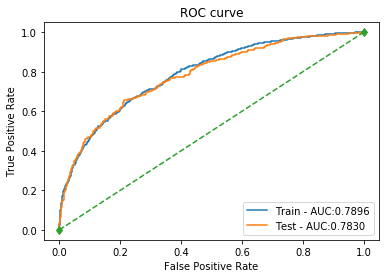

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

# 预测
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# 预测概率
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

<a id='2.2'></a>
## SVM模型

[准确率]
训练集：0.8665
测试集：0.7877
[精准率]
训练集：0.9413
测试集：0.7068
[召回率]
训练集：0.4994
测试集：0.2626
[f1 score]
训练集：0.6526
测试集：0.3829
[auc]
训练集：0.9436
测试集：0.7303
[roc曲线]


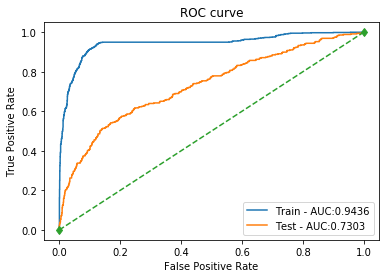

In [54]:
from sklearn.svm import SVC

svc = SVC(C=1.0, kernel='rbf', gamma=0.1, probability=True)
svc.fit(X_train, y_train)

# 预测
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
# 预测概率
y_train_proba = svc.predict_proba(X_train)[:, 1]
y_test_proba = svc.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

[准确率]
训练集：0.7857
测试集：0.7828
[精准率]
训练集：0.7773
测试集：0.7791
[召回率]
训练集：0.2048
测试集：0.1872
[f1 score]
训练集：0.3242
测试集：0.3018
[auc]
训练集：0.7899
测试集：0.7875
[roc曲线]


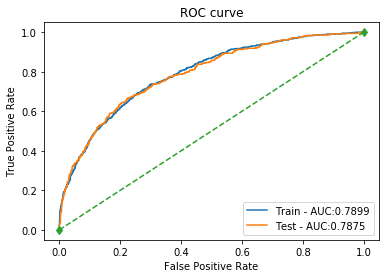

In [55]:
# LinearSVC模型
lin_svc = SVC(kernel='linear', probability=True)
lin_svc.fit(X_train,y_train)

# 预测
y_train_pred = lin_svc.predict(X_train)
y_test_pred = lin_svc.predict(X_test)
# 预测概率
y_train_proba = lin_svc.predict_proba(X_train)[:, 1]
y_test_proba = lin_svc.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

# print y_train[0:100]
# print y_test_pred[0:100]
# print y_test_pred[100:200]

# SVM预测结果都是同一个值，可能原因有：1. 可能是由于样本数据没有归一化导致的。由于维度太大，如果不采用归一化处理的话，各个点的距离值将非常大，
# 故模型对于待预测点的预测结果值都判为同一个值。2. 也有可能是参数的问题。

<a id='2.3'></a>
## DT模型

[准确率]
训练集：0.7018
测试集：0.6734
[精准率]
训练集：0.4427
测试集：0.4121
[召回率]
训练集：0.7269
测试集：0.7067
[f1 score]
训练集：0.5503

/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)



测试集：0.5206
[auc]
训练集：0.7829
测试集：0.7358
[roc曲线]


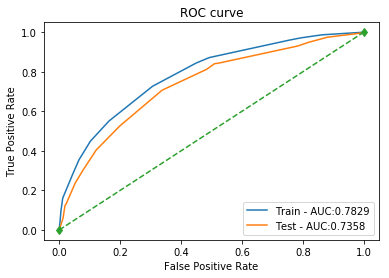

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

dt.fit(X_train, y_train)

# 预测
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
# 预测概率
y_train_proba = dt.predict_proba(X_train)[:, 1]
y_test_proba = dt.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

# print y_test_pred[0:100]

<a id='2.4'></a>
## XGBoost模型

[准确率]
训练集：0.8419
测试集：0.7905
[精准率]
训练集：0.8472
测试集：0.6482
[召回率]
训练集：0.4515
测试集：0.3603
[f1 score]
训练集：0.5891
测试集：0.4632
[auc]
训练集：0.8921
测试集：0.7892
[roc曲线]


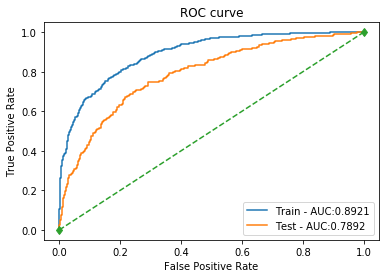

In [57]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 预测
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
# 预测概率
y_train_proba = xgb.predict_proba(X_train)[:, 1]
y_test_proba = xgb.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

In [ ]:
[准确率]
训练集：0.8479
测试集：0.7898
[精准率]
训练集：0.8553
测试集：0.6343
[召回率]
训练集：0.4743
测试集：0.3827
[f1 score]
训练集：0.6102
测试集：0.4774
[auc]
训练集：0.9089
测试集：0.7924
[roc曲线]

<a id='2.5'></a>
## LightGBM模型

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

# 预测
y_train_pred = lgb.predict(X_train)
y_test_pred = lgb.predict(X_test)
# 预测概率
y_train_proba = lgb.predict_proba(X_train)[:, 1]
y_test_proba = lgb.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

# 模型评估

评估结果

| 模型 | 准确率 | 精准率 | 召回率 | F1 score | AUC | ROC |
| :------ | :------ | :------ | :------ | :------ | :------ | :------ |
| lr | 0.8025; 0.8038 | 0.7051; 0.6990 | 0.3665; 0.3827 | 0.4823; 0.4946 | 0.8105; 0.7897 | ![lr](images/lr.png) |
| svm_linear | 0.7920; 0.7926 | 0.7424; 0.7385 | 0.2623; 0.2682 | 0.3876; 0.3934 | 0.8088; 0.7926 | ![svm_linear](images/linear_svm.png) |
| svm_rbf | 0.9940; 0.7519 | 1.0000; 0.7000 | 0.9760; 0.0196 | 0.9879; 0.0380 | 1.0000; 0.6997 | ![svm_rbf](images/svm.png) |
| dt | 0.7027; 0.6685 | 0.4444; 0.4080 | 0.7377; 0.7123 | 0.5547; 0.5188 | 0.7832; 0.7207 | ![dt](images/dt.png) |
| xgb | 0.8479; 0.7898 | 0.8553; 0.6343 | 0.4743; 0.3827 | 0.6102; 0.4774 | 0.9089; 0.7924 | ![xgb](images/xgb.png) |
| lgb | 0.8479; 0.7898 | 0.8553; 0.6343 | 0.4743; 0.3827 | 0.6102; 0.4774 | 0.9089; 0.7924 | ![xgb](images/xgb.png) |

# 模型调优

交叉验证和网格搜索：

* 交叉验证：将拿到的数据，分为训练集和验证集（注意这里的数据是在训练集中进行划分的，也就是将原始数据划分得到的训练集再次划分为训练集和验证集），交叉验证一般结合网格搜索使用。
* 网格搜素：对模型预设几种超参数组合。每组超参数都采用交叉验证来进行评估。最后选出最优参数组合建立模型。

[模型的选择与调优：交叉验证与网格搜索](https://mp.weixin.qq.com/s/i4uELGZFdqhHY8aVRVklDA)

In [422]:
from sklearn.model_selection import GridSearchCV

# GridSearchCV(estimator, param_grid=None,cv=None)
# 对估计器的指定参数值进行详尽搜索

# estimator：估计器对象 就是哪一个模型
# param_grid：估计器参数(dict){“n_neighbors”:[1,3,5]}
# cv：指定几折交叉验证

# fit：输入训练数据
# score：准确率

# 结果分析：
# best_score_:在交叉验证中测试的最好结果
# best_estimator_：最好的参数模型
# cv_results_:每次交叉验证后的测试集准确率结果和训练集准确率结果
    
# lr
# svc
# lin_svc
# dt
# xgb


# 参数
lr_param = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100],
    'penalty': ['l1', 'l2']
}
svc_param = {
    'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'class_weight': ['balanced',None] 
}
lin_svc_param = {
    'C': [0.01, 0.05, 0.1, 0.5, 1]
}
dt_param = {
    'max_depth': [m for m in range(3,8)], 
    'min_sample_split': range(2, 100, 5), 
    'class_weight': ['balanced',None]
}
xgb_param = {
    "max_depth": [10,30,50],
    "min_child_weight": [1,3,6],
    "n_estimators": [200],
    "learning_rate": [0.05, 0.1,0.16]
}
lgb_param = {
    "max_depth": [5,10, 15],
    "learning_rate" : [0.01,0.05,0.1],
    "num_leaves": [30,90,120],
    "n_estimators": [20]
}
scoring = 'roc_auc'  # 评价标准
n_fold = 5  # n折交叉验证

## LR模型

In [160]:
lr_grid = GridSearchCV(lr, lr_param, cv=n_fold, scoring=scoring)
lr_grid.fit(X_train, y_train)
print '最优分数：', lr_grid.best_score_ # 最优分数
print '最优参数：', lr_grid.best_params_ # 最优参数
# print '交叉验证结果：', lr_grid.cv_results_ # 结果
 
# 把参数重新赋值给原模型
# lr.set_params(**lr_grid.best_params_)
# lr.fit(X_train, y_train)

最优分数： 0.788989992938
最优参数： {'penalty': 'l1', 'C': 0.05}


[准确率]
训练集：0.7971
测试集：0.8024
[精准率]
训练集：0.7198
测试集：0.7262
[召回率]
训练集：0.3138
测试集：0.3408
[f1 score]
训练集：0.4370
测试集：0.4639
[auc]
训练集：0.8007
测试集：0.7942
[roc曲线]


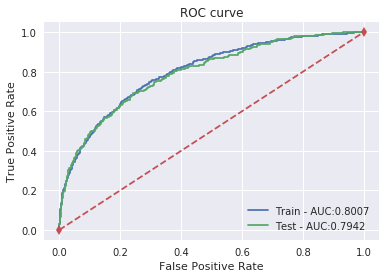

In [483]:
lr_ = LogisticRegression(C = 0.05, penalty = 'l1')
lr_.fit(X_train, y_train)
# 预测
y_train_pred = lr_.predict(X_train)
y_test_pred = lr_.predict(X_test)
# 预测概率
y_train_proba = lr_.predict_proba(X_train)[:, 1]
y_test_proba = lr_.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

## SVM模型

In [312]:
svc_grid = GridSearchCV(svc, svc_param, cv=n_fold, scoring=scoring)
svc_grid.fit(X_train, y_train)
print '最优分数：', svc_grid.best_score_ # 最优分数
print '最优参数：', svc_grid.best_params_ # 最优参数
# print '交叉验证结果：', svc_grid.cv_results_ # 结果

最优分数： 0.774302939611
最优参数： {'C': 0.01, 'gamma': 0.01, 'class_weight': None}


In [313]:
lin_svc_grid = GridSearchCV(lin_svc, lin_svc_param, cv=n_fold, scoring=scoring)
lin_svc_grid.fit(X_train, y_train)
print '最优分数：', lin_svc_grid.best_score_ # 最优分数
print '最优参数：', lin_svc_grid.best_params_ # 最优参数
# print '交叉验证结果：', lin_svc_grid.cv_results_ # 结果

最优分数： 0.781479503689
最优参数： {'C': 0.01}


[准确率]
训练集：0.7490
测试集：0.7491
[精准率]
训练集：0.0000
测试集：0.0000
[召回率]
训练集：0.0000
测试集：0.0000
[f1 score]
训练集：0.0000
测试集：0.0000
[auc]
训练集：0.8602
测试集：0.7820
[roc曲线]


/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  else:
/Users/wangzhongpu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  else:


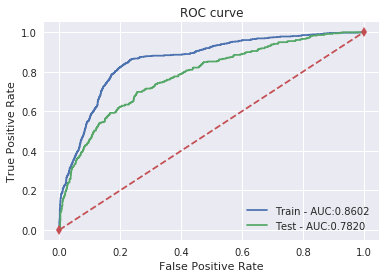

In [324]:
svc_ = SVC(C=0.01, kernel='rbf', gamma=0.01, class_weight=None, probability=True)
svc_.fit(X_train, y_train)

# 预测
y_train_pred = svc_.predict(X_train)
y_test_pred = svc_.predict(X_test)
# 预测概率
y_train_proba = svc_.predict_proba(X_train)[:, 1]
y_test_proba = svc_.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

[准确率]
训练集：0.7896
测试集：0.7891
[精准率]
训练集：0.7974
测试集：0.7938
[召回率]
训练集：0.2168
测试集：0.2151
[f1 score]
训练集：0.3409
测试集：0.3385
[auc]
训练集：0.8071
测试集：0.7934
[roc曲线]


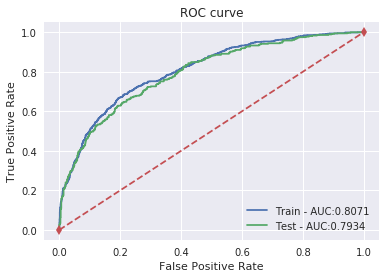

In [336]:
lin_svc_ = SVC(C=0.01, kernel='linear', probability=True)
lin_svc_.fit(X_train,y_train)

# 预测
y_train_pred = lin_svc_.predict(X_train)
y_test_pred = lin_svc_.predict(X_test)
# 预测概率
y_train_proba = lin_svc_.predict_proba(X_train)[:, 1]
y_test_proba = lin_svc_.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

## DT模型

In [318]:
dt_param = {
    'max_depth': [m for m in range(3,8)], 
    'min_samples_split': range(2, 100, 5), 
    'class_weight': ['balanced',None]
}
dt_grid = GridSearchCV(dt, dt_param, cv=n_fold, scoring=scoring)
dt_grid.fit(X_train, y_train)
print '最优分数：', dt_grid.best_score_ # 最优分数
print '最优参数：', dt_grid.best_params_ # 最优参数
# print '交叉验证结果：', dt_grid.cv_results_ # 结果

最优分数： 0.729497046466
最优参数： {'min_samples_split': 72, 'max_depth': 5, 'class_weight': 'balanced'}


## XGBoost模型

In [ ]:
xgb_grid = GridSearchCV(xgb, xgb_param, cv=n_fold, scoring=scoring)
xgb_grid.fit(X_train, y_train)
print '最优分数：', xgb_grid.best_score_ # 最优分数
print '最优参数：', xgb_grid.best_params_ # 最优参数
# print '交叉验证结果：', xgb_grid.cv_results_ # 结果

## LightGBM模型

In [ ]:
lgb_grid = GridSearchCV(lgb, lgb_param, cv=n_fold, scoring=scoring)
lgb_grid.fit(X_train, y_train)
print '最优分数：', lgb_grid.best_score_ # 最优分数
print '最优参数：', lgb_grid.best_params_ # 最优参数
# print '交叉验证结果：', lgb_grid.cv_results_ # 结果

# 模型融合

## 参考

[stacking代码参考](https://github.com/emanuele/kaggle_pbr/blob/master/blend.py#L76)

[StackingCVClassifier](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/)

[StackingClassifier](https://www.jianshu.com/p/1df64dee0c05)

## 自己写接口

In [58]:
def blend(clfs, X, y, X_submission):
    from sklearn.model_selection import StratifiedKFold
    
    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))
    
    n_folds = 5
    # skf = list(StratifiedKFold(y, n_folds))
    skf = StratifiedKFold(n_folds)
    skf_data = []
    
    for train, test in skf.split(X, y):
        skf_data_temp = [train, test]
        skf_data.append(skf_data_temp)
    
    print "Creating train and test sets for blending."
    
    for j, clf in enumerate(clfs):
        print j, clf
        dataset_blend_test_j = np.zeros((X_submission.shape[0], n_folds))
        for i, (train, test) in enumerate(skf_data):
            print "Fold", i
            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]
            
            clf.fit(X_train, y_train)
            y_submission = clf.predict_proba(X_test)[:, 1]
            dataset_blend_train[test, j] = y_submission
            dataset_blend_test_j[:, i] = clf.predict_proba(X_submission)[:, 1]
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    
    print "Blending."
    clf = LogisticRegression()
    clf.fit(dataset_blend_train, y)
    y_submission_proba = clf.predict_proba(dataset_blend_test)[:, 1]
    y_submission = clf.predict(dataset_blend_test)
    return y_submission_proba, y_submission

In [59]:
clfs = [LogisticRegression(C = 0.05, penalty = 'l1'), 
        SVC(C=0.01, kernel='rbf', gamma=0.01, probability=True), 
        SVC(C=0.01, kernel='linear', probability=True), 
        DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=72,), 
        XGBClassifier()]
y_submission_proba, y_submission = blend(clfs, X_train, y_train, X_test)

Creating train and test sets for blending.
0 LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
1 SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
2 SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
3 DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_lea

融合之后，指标略有提升。

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve

print '[准确率]'
print '测试集：{:.4f}'.format(accuracy_score(y_test, y_submission))
print '[精准率]'
print '测试集：{:.4f}'.format(precision_score(y_test, y_submission))
print '[召回率]'
print '测试集：{:.4f}'.format(recall_score(y_test, y_submission))
print '[f1 score]'
print '测试集：{:.4f}'.format(f1_score(y_test, y_submission))
print '[auc]'
print '测试集：{:.4f}'.format(roc_auc_score(y_test, y_submission_proba))

[准确率]
测试集：0.8045
[精准率]
测试集：0.7090
[召回率]
测试集：0.3743
[f1 score]
测试集：0.4899
[auc]
测试集：0.8015


## 采用已有的接口

Fitting 5 classifiers...
Fitting classifier1: logisticregression (1/5)
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)
[LibLinear]Fitting classifier2: svc (2/5)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=1)
[LibSVM]Fitting classifier3: svc (3/5)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=1)
[LibSVM]Fitting classifier4: decisiontreeclassifier (4/5)
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_d

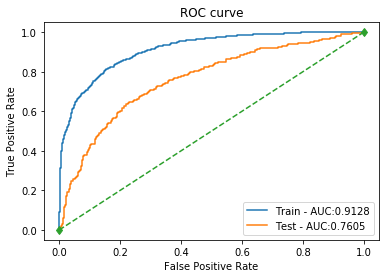

In [60]:
from mlxtend.classifier import StackingClassifier

# 构建Stacking 模型
s_clf = StackingClassifier(
    classifiers=[
        LogisticRegression(C = 0.05, penalty = 'l1'), 
        SVC(C=0.01, kernel='rbf', gamma=0.01, probability=True), 
        SVC(C=0.01, kernel='linear', probability=True), 
        DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=72,), 
        XGBClassifier()
    ], 
    meta_classifier=LogisticRegression(), use_probas=True, verbose=3)

s_clf.fit(X_train, y_train)

# 预测
y_train_pred = s_clf.predict(X_train)
y_test_pred = s_clf.predict(X_test)
# 预测概率
y_train_proba = s_clf.predict_proba(X_train)[:, 1]
y_test_proba = s_clf.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

In [ ]:
特征选择前结果：
Fitting 5 classifiers...
Fitting classifier1: logisticregression (1/5)
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)
[LibLinear]Fitting classifier2: svc (2/5)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=1)
[LibSVM]Fitting classifier3: svc (3/5)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=1)
[LibSVM]Fitting classifier4: decisiontreeclassifier (4/5)
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=72,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Fitting classifier5: xgbclassifier (5/5)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[准确率]
训练集：0.8801
测试集：0.7758
[精准率]
训练集：0.8293
测试集：0.5638
[召回率]
训练集：0.6575
测试集：0.4693
[f1 score]
训练集：0.7335
测试集：0.5122
[auc]
训练集：0.9297
测试集：0.7679

特征选择后结果：
Fitting 5 classifiers...
Fitting classifier1: logisticregression (1/5)
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)
[LibLinear]Fitting classifier2: svc (2/5)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=1)
[LibSVM]Fitting classifier3: svc (3/5)
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=1)
[LibSVM]Fitting classifier4: decisiontreeclassifier (4/5)
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=72,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Fitting classifier5: xgbclassifier (5/5)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[准确率]
训练集：0.8687
测试集：0.7765
[精准率]
训练集：0.8139
测试集：0.5661
[召回率]
训练集：0.6180
测试集：0.4665
[f1 score]
训练集：0.7025
测试集：0.5115
[auc]
训练集：0.9128
测试集：0.7605

In [ ]:
from sklearn.model_selection import StratifiedKFold
    
# dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
# dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))


#idx = np.random.permutation(y.size)
#X = X[idx]
#y = y[idx]
print type(y_train)
# print y_train
print y_train[[665]]

clfs[0].fit(X_train, y_train)
        
n_folds = 5
skf = StratifiedKFold(5)
    
print "Creating train and test sets for blending."
    
#for j, clf in enumerate(clfs):
    #print j, clf
# dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))
for (train_index, test_index) in (skf.split(X_train, y_train)):
        X_train_ = (X_train[train_index])
        y_train_ = pd.Series((y_train[train_index]))
        X_test_ = (X_train[test_index])
        y_test_ = pd.Series((y_train[test_index]))

        # print np.argwhere(np.isnan(X_train))
        # print np.argwhere(np.isnan(X_train_))
        
        print type(y_train)
        print y_train[[665]]
        print type(y_train_)
        print y_train_[[665]]
        #print np.isfinite(y_train)
        #print np.isfinite(y_train_)
            
        clfs[0].fit(X_train, y_train)
        clfs[0].fit(X_train_, y_train_)
        # y_submission = clf.predict_proba(X_test)[:, 1]
        # dataset_blend_train[test, j] = y_submission
        # dataset_blend_test_j[:, i] = clf.predict_proba(X_submission)[:, 1]
# dataset_blend_test[:, j] = dataset_blend_test_j.mean(